# Performance analysis
This notebook is create to compare the performance of different algorithms for graphical inference, namely graphical lasso (GL or GLASSO), latent graph lasso (LVGLASSO), time-varying graphical lasso (TVGL) wuth our method, latent variable time-varying graphical lasso (LVGL).

## Before proceeding
Other methods are not necessarily implemented in Python. Therefore, this is a list of required steps in order to successfully install the code.

### Install instructions for
#### 1a. GL (scikit-learn implementation)
For this, it is not required to do anything, as `sklearn` should be already installed in your system as it is a dependency of `regain`. Otherwise, install it as first thing with 
```
conda install scikit-learn
```
or 
```
pip install scikit-learn
```

#### 1b. GLASSO (R implementation)
This is the R implementation for graphical lasso, called GLASSO. It is available as an R package, thus requiring R installed in your system. Then, in R console (simply call `R` from a command line):
```R
install.packages("glasso")
```
Refer to [GLASSO documentation](https://cran.r-project.org/web/packages/glasso/glasso.pdf) for further information.

#### 2. LVGLASSO (Matlab implementation)
This requires to have [Matlab installed](https://it.mathworks.com/help/install/ug/install-mathworks-software.html) (version2016b or higher) and [Matlab engine for Python](https://it.mathworks.com/help/matlab/matlab_external/install-the-matlab-engine-for-python.html).
Then, [download the code](https://www.math.ucdavis.edu/~sqma/ADMM-LVGLasso) and unpack the folder.
Ensure to have a file called `ADMM_B.m`. Save the location of the code, as it will be necessary to call the `ADMM_B.m` script.

**NOTE:** There is a so-called [LVGLASSO in the R packages](https://www.rdocumentation.org/packages/lvnet/versions/0.3.2/topics/lvglasso). Note that THIS IS NOT RIGHT, as it is implemented in a different way and it requires to specify a priori the number of latent variables. See the link above for further details.

**NOTE 2:** Our `regain` package has a Python wrapper that ease the calling of such Matlab functions. Therefore, conversions of numpy arrays to Matlab matrices are done under the hood from the script `regain/wrappers/lvglasso/LVGLASSO.m`.

#### 3. TVGL (Python implementation)
Since it is a Python implementation, this does not require additional software (beside having `git` installed). However, there is a little modification in the source code to do in order to obtain additional results, such as the number of iterations and the estimated covariance matrices.

1. Clone the repo (https://github.com/davidhallac/TVGL) in a folder, with
```bash
git clone https://github.com/davidhallac/TVGL.git
```
Its requirements are [`cvxpy`](http://www.cvxpy.org/en/latest/install/index.html) and [`snap`](https://snap.stanford.edu/snappy/) installed. 

2. Modify the line 76 of ./TVGL/TVGL.py (ie, `return thetaSet`) with 
```
return thetaSet, empCovSet, gvx.status, gvx
```
3. Add after the line 454 of ./TVGL/inferGraphL2.py (and other norms if required)
```
self.n_iter_ = num_iterations
```

#### 4. REGAIN
Of course, first of all you should download and install the `regain` package (our method). If you haven't done it yet, do it now!

```
conda install -c fdtomasi regain
```
or
```
pip install regain
```

Or, you have the source code, `mv` to the `regain` folder, then
```
python setup.py install
```

and that's it. Now you are good to go!

In [1]:
%matplotlib inline
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
import matlab.engine
import matlab
import pandas as pd

from itertools import product
from scipy.io import loadmat
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.datasets.base import Bunch
from sklearn.utils.extmath import squared_norm
from sklearn.covariance import empirical_covariance
from sklearn.model_selection import GridSearchCV, ShuffleSplit

from regain import datasets; reload(datasets)
from regain.admm import graph_lasso_; reload(graph_lasso_);
from regain.admm import time_graph_lasso_; reload(time_graph_lasso_);
from regain.admm import latent_graph_lasso_; reload(latent_graph_lasso_);
from regain.admm import latent_time_graph_lasso_; reload(latent_time_graph_lasso_);
from regain import utils; reload(utils)
import time

# Performances of the different algorithms

In [344]:
def gl_results(data_grid, K, K_obs, ells, **params):
    
    mdl = graph_lasso_.GraphLasso(
        assume_centered=0, verbose=0, rtol=1e-5, tol=1e-5,
        max_iter=500, rho=1./ np.sqrt(data_grid.shape[0]))
    
    tic = time.time()
    iters = []
    precisions = []
    for d in data_grid.transpose(2,0,1):
        mdl.set_params(**params).fit(d)
        iters.append(mdl.n_iter_)
        precisions.append(mdl.precision_)
    tac = time.time()
    iterations = np.max(iters)
    precisions = np.array(precisions)

    F1score = utils.structure_error(K, precisions)['f1']
    MSE_observed = None # utils.error_norm(K_obs, precisions - latents)
    MSE_precision = utils.error_norm(K, precisions)
    MSE_latent = None#utils.error_norm(ells, latents)
    mean_rank_error = None#utils.error_rank(ells, latents)
    
    res = dict(n_dim_obs=K.shape[1],
               time=tac-tic,
               iterations=iterations,
               F1score=F1score,
               MSE_precision=MSE_precision,
               MSE_observed=MSE_observed,
               MSE_latent=MSE_latent,
               mean_rank_error=mean_rank_error,
               note=None,
               estimator=mdl)
    return res

def lgl_results(data_grid, K, K_obs, ells, **params):
    
    mdl = latent_graph_lasso_.LatentGraphLasso(
        assume_centered=0, verbose=0, rtol=1e-5, tol=1e-5,
        max_iter=500, rho=1./ np.sqrt(data_grid.shape[0]))
    
    tic = time.time()
    iters = []
    precisions, latents = [], []
    for d in data_grid.transpose(2,0,1):
        mdl.set_params(**params).fit(d)
        iters.append(mdl.n_iter_)
        precisions.append(mdl.precision_)
        latents.append(mdl.latent_)
    tac = time.time()
    iterations = np.max(iters)
    precisions = np.array(precisions)
    latents = np.array(latents)

    F1score = utils.structure_error(K, precisions)['f1']
    MSE_observed = utils.error_norm(K_obs, precisions - latents)
    MSE_precision = utils.error_norm(K, precisions)
    MSE_latent = utils.error_norm(ells, latents)
    mean_rank_error = utils.error_rank(ells, latents)
    
    res = dict(n_dim_obs=K.shape[1],
               time=tac-tic,
               iterations=iterations,
               F1score=F1score,
               MSE_precision=MSE_precision,
               MSE_observed=MSE_observed,
               MSE_latent=MSE_latent,
               mean_rank_error=mean_rank_error,
               note=None,
               estimator=mdl)
    return res

def tgl_results(data_grid, K, K_obs, ells, **params):
    
    mdl = time_graph_lasso_.TimeGraphLasso(
        bypass_transpose=False, assume_centered=0, verbose=0, rtol=1e-5, tol=1e-5,
        max_iter=500, rho=1./ np.sqrt(data_grid.shape[0]))
    
    tic = time.time()
    ll = mdl.set_params(**params).fit(data_grid)
    tac = time.time()
    iterations = ll.n_iter_
    F1score = utils.structure_error(K, ll.precision_)['f1']
    MSE_observed = None # utils.error_norm(K_obs, ll.precision_ - ll.latent_)
    MSE_precision = utils.error_norm(K, ll.precision_)
    MSE_latent = None # utils.error_norm(ells, ll.latent_)
    mean_rank_error = None # utils.error_rank(ells, ll.latent_)
    
    res = dict(n_dim_obs=K.shape[1],
               time=tac-tic,
               iterations=iterations,
               F1score=F1score,
               MSE_precision=MSE_precision,
               MSE_observed=MSE_observed,
               MSE_latent=MSE_latent,
               mean_rank_error=mean_rank_error,
               note=None,
               estimator=ll)
    return res

def ltgl_results(data_grid, K, K_obs, ells, **params):
    
    reload(latent_time_graph_lasso_)
    mdl = latent_time_graph_lasso_.LatentTimeGraphLasso(
        bypass_transpose=False, assume_centered=0, verbose=0, rtol=1e-5, tol=1e-5,
        max_iter=1000, rho=1./ np.sqrt(data_grid.shape[0]), update_rho_options=dict(mu=5))
    
    tic = time.time()
    ll = mdl.set_params(**params).fit(data_grid)
    tac = time.time()
    iterations = ll.n_iter_
    ss = utils.structure_error(K, ll.precision_)#, thresholding=1, eps=1e-5)
    MSE_observed = utils.error_norm(K_obs, ll.precision_ - ll.latent_)
    MSE_precision = utils.error_norm(K, ll.precision_)
    MSE_latent = utils.error_norm(ells, ll.latent_)
    mean_rank_error = utils.error_rank(ells, ll.latent_)
    
    res = dict(n_dim_obs=K.shape[1],
               time=tac-tic,
               iterations=iterations,
               MSE_precision=MSE_precision,
               MSE_observed=MSE_observed,
               MSE_latent=MSE_latent,
               mean_rank_error=mean_rank_error,
               note=None,
               estimator=ll,
              latent=ll.latent_)
    
    res = dict(res, **ss)
    return res  

In [3]:
from sklearn.covariance import GraphLasso
def glasso_results(data_grid, K, K_obs, ells, alpha):
    gl = GraphLasso(alpha=alpha, mode='cd', assume_centered=False, max_iter=500)
    
    tic = time.time()
    iters = []
    precisions = []
    for d in data_grid.transpose(2,0,1):
        gl.fit(d)
        iters.append(gl.n_iter_)
        precisions.append(gl.precision_)
    tac = time.time()
    iterations = np.max(iters)
    precisions = np.array(precisions)

    ss = utils.structure_error(K, precisions)#, thresholding=1, eps=1e-5)
    
    MSE_observed = None
    MSE_precision = utils.error_norm(K, precisions)
    MSE_latent = None
    mean_rank_error = None
 
    res = dict(n_dim_obs=K.shape[1],
               time=tac-tic,
               iterations=iterations,
               MSE_precision=MSE_precision,
               MSE_observed=MSE_observed,
               MSE_latent=MSE_latent,
               mean_rank_error=mean_rank_error,
               note=None,
               estimator=gl)
    
    res = dict(res, **ss)
    return res

# from rpy2.robjects.packages import importr
# glasso = importr('glasso').glasso

def friedman_results(data_grid, K, K_obs, ells, alpha):
    tic = time.time()
    iters = []
    precisions = []
    for d in data_grid.transpose(2,0,1):
        emp_cov = empirical_covariance(d)
        out = glasso(emp_cov, alpha)
        iters.append(int(out[-1][0]))
        precisions.append(np.array(out[1]))
    tac = time.time()
    iterations = np.max(iters)
    precisions = np.array(precisions)
    F1score = utils.structure_error(K, precisions)['f1']
    MSE_observed = None
    MSE_precision = utils.error_norm(K, precisions)
    MSE_latent = None
    mean_rank_error = None
 
    res = dict(n_dim_obs=K.shape[1],
               time=tac-tic,
               iterations=iterations,
               F1score=F1score,
               MSE_precision=MSE_precision,
               MSE_observed=MSE_observed,
               MSE_latent=MSE_latent,
               mean_rank_error=mean_rank_error,
               note=None,
               estimator=None)
    
 
    return res

In [4]:
import sys; sys.path.append("/home/fede/src/TVGL")
import inferGraphLaplacian; reload(inferGraphLaplacian)
import TVGL; reload(TVGL)
from regain import utils; reload(utils)
from regain.utils import suppress_stdout

def hallac_results(data_grid, K, K_obs, ells, beta, alpha, penalty=2):
    
#     with suppress_stdout():
    tic = time.time()
    thetaSet, empCovSet, status, gvx = TVGL.TVGL(
        np.vstack(data_grid.transpose(2,0,1)), data_grid.shape[0], lamb=alpha, beta=beta,
        indexOfPenalty=penalty)
    tac = time.time()

    if status != "Optimal":
        print ("not converged")
    precisions = np.array(thetaSet)
    ss = utils.structure_error(K, precisions)
    MSE_observed = None
    MSE_precision = utils.error_norm(K, precisions)
    MSE_latent = None
    mean_rank_error = None

    res = dict(n_dim_obs=K.shape[1],
               time=tac-tic,
               iterations=gvx.n_iter_,
               MSE_precision=MSE_precision,
               MSE_observed=MSE_observed,
               MSE_latent=MSE_latent,
               mean_rank_error=mean_rank_error,
               note=status,
               estimator=gvx)
    res = dict(res, **ss)

    return res

In [5]:
try:
    eng.quit()
except:
    pass
eng = matlab.engine.start_matlab()
eng.addpath(r'/home/fede/src/slipguru/regain/regain/wrapper/lvglasso/',nargout=0)
# eng.addpath(r'path/to/ADMM_B.m/',nargout=0)

In [345]:
def chandresekeran_results(data_grid, K, K_obs, ells, tau, alpha, **whatever):
   
    emp_list = np.array([empirical_covariance(x, assume_centered=True)
                        for x in data_grid.transpose(2,0,1)]).transpose(1,2,0)
    
    n_samples = emp_list.shape[0]
    rho = 1./ np.sqrt(data_grid.shape[0])

    # 3. Matlab engine
    result = eng.LVGLASSO(matlab.double(emp_list.tolist()),float(alpha),float(tau),float(rho))
    ma_output = Bunch(**result)

    R = np.array(ma_output.R)
    S = np.array(ma_output.S)
    L = np.array(ma_output.L)
    
    ss = utils.structure_error(K, S) # , thresholding=1, eps=1e-3)
    MSE_observed = utils.error_norm(K_obs, R)
    MSE_precision = utils.error_norm(K, S)
    MSE_latent = utils.error_norm(ells, L)
    mean_rank_error = utils.error_rank(ells, L)
    
    res = dict(n_dim_obs=K.shape[1],
               time=ma_output.elapsed_time,
               iterations=np.max(ma_output.iter),
               MSE_precision=MSE_precision,
               MSE_observed=MSE_observed,
               MSE_latent=MSE_latent,
               mean_rank_error=mean_rank_error,
               note=None, estimator=ma_output,
              latent=L)
 
    res = dict(res, **ss)
    return res

### Comparison

In [292]:
# setting 1
alpha = 0.45 #0.0025
tau = 3
beta = 50 # 1000
eta = 10

n_samples = 100
n_dim_lat = 20
T = 10
n_dim_obs = 100

k = (n_dim_obs, T)

np.random.seed(20)

mode = 'norm' # 'norm'
reload(datasets)
data = {(dim, T) : datasets.generate_dataset(
    mode=mode, n_samples=n_samples, n_dim_lat=n_dim_lat, n_dim_obs=dim,  T=T, epsilon=1e-1,
    proportional=True, degree=2, keep_sparsity=True)
    for dim in [n_dim_obs]}

In [475]:
# setting 2
alpha = .43
tau = 1.9
beta = 1
eta = 2

n_samples = 100 # 500
n_dim_lat = 5
T = 100
n_dim_obs = 50

k = (n_dim_obs, T)

np.random.seed(20)
reload(datasets)
data = {(dim, T) : datasets.generate_dataset(
    mode='l1l1', n_samples=n_samples, n_dim_lat=n_dim_lat, n_dim_obs=dim,  T=T, epsilon=1e-1,
    proportional=False, degree=2, keep_sparsity=True)
    for dim in [n_dim_obs]}

In [207]:
K = data[k].thetas

print ([(i!=0).sum() for i in K])

[396, 396, 396, 396, 396, 396, 396, 396, 396, 396]


In [294]:
(data[k].thetas == 0).sum() / (n_dim_obs ** 2 * T)

0.96040000000000003

In [295]:
print([np.linalg.norm(data[k].thetas[i] - data[k].thetas[i+1]) for i in range(T-1)])
print([np.linalg.norm(data[k].ells[i] - data[k].ells[i+1]) for i in range(T-1)])

[0.083470470692657311, 0.08896597054059284, 0.089891783615316093, 0.089183451550001708, 0.088987959966147237, 0.089599861711833428, 0.08830111560847162, 0.087691070983808586, 0.088719277450987441]
[0.057718527138593476, 0.04972712578406125, 0.044492221289195125, 0.039562105385236523, 0.034760155424721821, 0.031916380593802515, 0.028762488957854083, 0.025641854429585831, 0.024131807566562743]


In [476]:
# prepare dataframe for results
n_dims = [n_dim_obs]
n_times = [T]
methods = ['LTGL ($\ell_2^2$)', 'LTGL ($\ell_1$)', 'GL', 'LVGLASSO', 'TVGL ($\ell_2^2$)', 'TVGL ($\ell_1$)']
scores = sorted(["MSE_precision", "MSE_observed", "MSE_latent", 'estimator',
                 "mean_rank_error", 'time','iterations', 'precision', 'recall', 'accuracy', 'balanced_accuracy',
                'f1', 'npv', 'prevalence', 'miss_rate',
                'specificity', 'plr',  'nlr'])

cols = pd.MultiIndex.from_product([scores, n_dims], names=('score','dim'))
rows = pd.MultiIndex.from_product([methods, n_times], names=('method','time'))

dff = pd.DataFrame(columns=cols, index=rows)
idx = pd.IndexSlice

In [477]:
reload(latent_time_graph_lasso_)
reload(utils)

<module 'regain.utils' from '/home/fede/src/slipguru/regain/regain/utils.pyc'>

In [478]:
# setting 1
# alpha = 0.361 #289 #0.0025
# tau = 1.12
# beta = 5e2
# eta = 5
# alpha_chandri_setting_1 = 0.29

# # setting 2
alpha = .43 #0.0025
tau = 1.99
beta = 2 # 1000
eta = 20
alpha_gl_setting_2 = .35

for i, (k, res) in enumerate(sorted(data.items())[:5]):
    dim = k[0]
    print("Start with: dim=%d, T=%d (it %d)" % (k[0],k[1], i))
    data_list = res.data
    K = res.thetas
    K_obs = res.thetas_observed
    ells = res.ells
    data_grid = np.array(data_list).transpose(1,2,0)  # to use it later for grid search

    print("starting LTGL l1...\r", end='')
    res_l = ltgl_results(data_grid, K, K_obs, ells, 
                       alpha=alpha, beta=beta, verbose=0, max_iter=1000,
                       tau=tau, eta=eta, psi='l1', phi='laplacian', tol=1e-5, rtol=1e-5)
    dff.loc[idx['LTGL ($\ell_1$)', k[1]], idx[:, k[0]]] = [res_l[x] for x in scores]
    
    print("starting LTGL l2...\r", end='')
    res_l = ltgl_results(data_grid, K, K_obs, ells, 
                       alpha=alpha, beta=beta,
                       tau=tau, eta=eta, psi='laplacian', phi='laplacian', tol=1e-5, rtol=1e-5)
    dff.loc[idx['LTGL ($\ell_2^2$)', k[1]], idx[:, k[0]]] = [res_l[x] for x in scores]
    
#     print("starting GL ...\r", end='')
#     try:
#         res = glasso_results(data_grid, K, K_obs, ells, alpha=alpha)

#         # res = friedman_results(data_grid, K, K_obs, ells, alpha=alpha)
#         dff.loc[idx['GL', k[1]], idx[:, k[0]]] = [res[x] for x in scores]
#     except Exception as e:
#         print(e)
    print("starting LVGLASSO...\r", end='')
    res_c = chandresekeran_results(data_grid, K, K_obs, ells,
                                            tau=tau, alpha=alpha)
    dff.loc[idx['LVGLASSO', k[1]], idx[:, k[0]]] = [res_c[x] for x in scores]
    
#     print("starting TVGL L1...\r", end='')
#     res = hallac_results(data_grid, K, K_obs, ells, beta=beta, alpha=alpha, penalty=1)
#     dff.loc[idx['TVGL ($\ell_1$)', k[1]], idx[:, k[0]]] = [res[x] for x in scores]
    
#     print("starting TVGL L22...\r", end='')
#     res = hallac_results(data_grid, K, K_obs, ells, beta=beta, alpha=alpha, penalty=3)
#     dff.loc[idx['TVGL ($\ell_2^2$)', k[1]], idx[:, k[0]]] = [res[x] for x in scores]

Start with: dim=50, T=100 (it 0)


In [479]:
mm = dff.xs(n_dim_obs, level='dim', axis=1).xs(T, level='time')
mm

score,MSE_latent,MSE_observed,MSE_precision,accuracy,balanced_accuracy,estimator,f1,iterations,mean_rank_error,miss_rate,nlr,npv,plr,precision,prevalence,recall,specificity,time
method,,,,,,,,,,,,,,,,,,
LTGL ($\ell_2^2$),0.466595,64.1316,66.7254,0.97424,0.880859,"LatentTimeGraphLasso(alpha=0.43, assume_center...",0.84166,92,0.29,0.23281,0.234091,0.977577,140.194,0.932142,0.08924,0.76719,0.994528,18.1763
LTGL ($\ell_1$),0.491084,64.5643,67.1968,0.98052,0.900438,"LatentTimeGraphLasso(alpha=0.43, assume_center...",0.880338,902,0.28,0.197042,0.197453,0.98102,385.708,0.974222,0.08924,0.802958,0.997918,177.052
GL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LVGLASSO,0.633148,63.3602,65.9032,0.964184,0.803371,"{u'elapsed_time': 89.666308, u'S': [[[0.689649...",0.751733,500,0.74,0.39238,0.392725,0.962945,691.745,0.985461,0.08924,0.60762,0.999122,89.6663
TVGL ($\ell_2^2$),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TVGL ($\ell_1$),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [480]:
l1 = ([np.linalg.matrix_rank(r) for r in mm.estimator['LTGL ($\ell_2^2$)'].latent_])
l2 = ([np.linalg.matrix_rank(r) for r in mm.estimator['LTGL ($\ell_1$)'].latent_])
l3 = ([np.linalg.matrix_rank(r) for r in mm.estimator['LVGLASSO'].L])

l4 = ([np.linalg.matrix_rank(r) for r in mm.estimator['LTGL ($\ell_2^2$)'].latent_])
l5 = ([np.linalg.matrix_rank(r) for r in mm.estimator['LTGL ($\ell_1$)'].latent_])
l6 = ([np.linalg.matrix_rank(r) for r in mm.estimator['LVGLASSO'].L])

In [2]:
l1,l2,l3,l4,l5,l6 = utils.load_pickle(filename="ells.pkl")

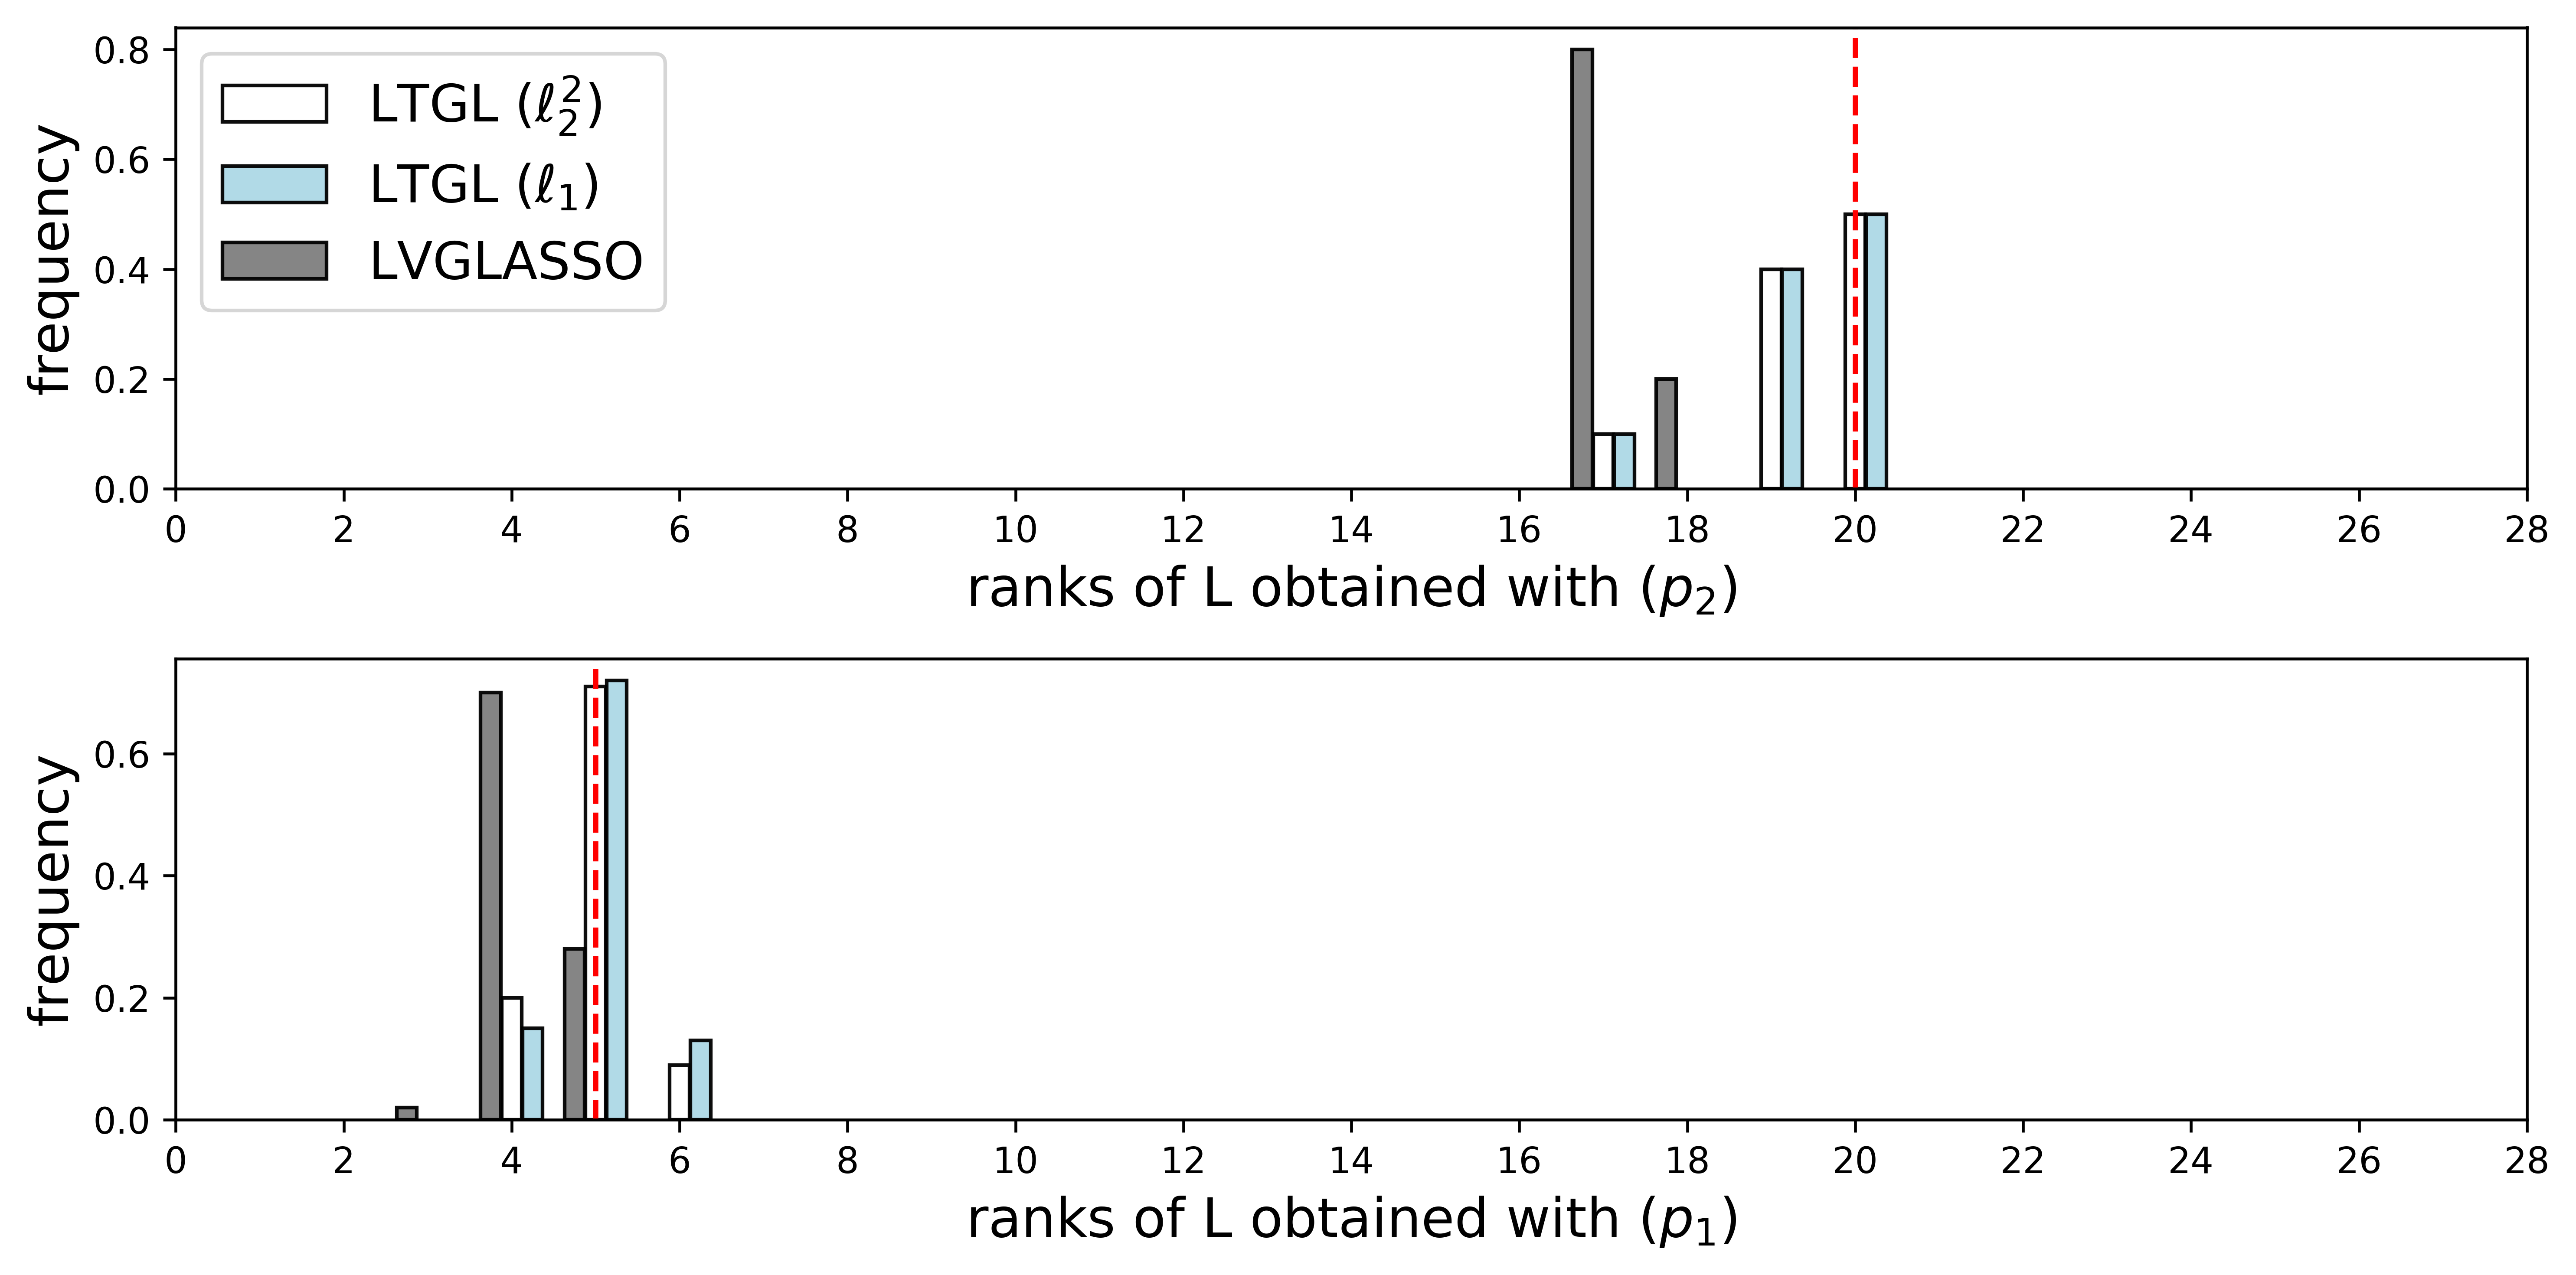

In [109]:
import collections
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(2,1, sharey=False, figsize=(10,5), dpi=600)

colors = ['white', 'lightblue', 'C7']
alpha = 0.95

counter=collections.Counter(l1)
ax1.bar(counter.keys(), np.array(counter.values())/len(l1), 
        alpha=alpha, width=0.24, label='LTGL ($\ell_2^2$)', color=colors[0], edgecolor='k')
counter=collections.Counter(l2)
ax1.bar(np.array(counter.keys())+0.25, np.array(counter.values())/len(l1), 
        alpha=alpha, width=0.24, label='LTGL ($\ell_1$)', color=colors[1], edgecolor='k')
counter=collections.Counter(l3)
ax1.bar(np.array(counter.keys())-0.25, np.array(counter.values())/len(l1), 
        alpha=alpha, width=0.24, label='LVGLASSO', color=colors[2], edgecolor='k')

ax1.set_xticks(range(0,30, 2))
#ax1.set_ylim(0,5)
ax1.axvline(20, c='r', ls='--')
ax1.set_xlabel(r'ranks of L obtained with ($p_2$)')
ax1.set_ylabel('frequency')
# ax1.set_xscale("log")
# ax1.set_xlim([10, 100])
ax1.xaxis.label.set_size(15)
ax1.yaxis.label.set_size(15)

#ax1.legend()
# ax0.legend(prop={'size': 10})
# ax0.set_title('bars with legend')


counter=collections.Counter(l4)
ax2.bar(counter.keys(), np.array(counter.values())/len(l4), 
        alpha=alpha, width=0.24, label='LTGL ($\ell_2^2$)', color=colors[0], edgecolor='k')
counter=collections.Counter(l5)
ax2.bar(np.array(counter.keys())+0.25,  
        np.array(counter.values())/len(l4), alpha=alpha, width=0.24, label='LTGL ($\ell_1$)', color=colors[1],
        edgecolor='k')
counter=collections.Counter(l6)
ax2.bar(np.array(counter.keys())-0.25,  
        np.array(counter.values())/len(l4), alpha=alpha, width=0.24, label='LVGLASSO', color=colors[2],
       edgecolor='k')

ax2.set_xticks(range(0,30,2))
# ax2.set_xlim(2.5,6.7)
ax2.set_xlabel(r'ranks of L obtained with ($p_1$)')
ax2.set_ylabel('frequency')
ax2.xaxis.label.set_size(15)
ax2.yaxis.label.set_size(15)
ax2.axvline(5, c='r', ls='--')
ax1.legend(loc='upper left', fontsize='x-large')
plt.tight_layout()
plt.show()

In [110]:
import matplotlib
f.savefig("ranks_distribution_vertical.pdf", dpi=600, transparent=True, bbox_inches='tight')

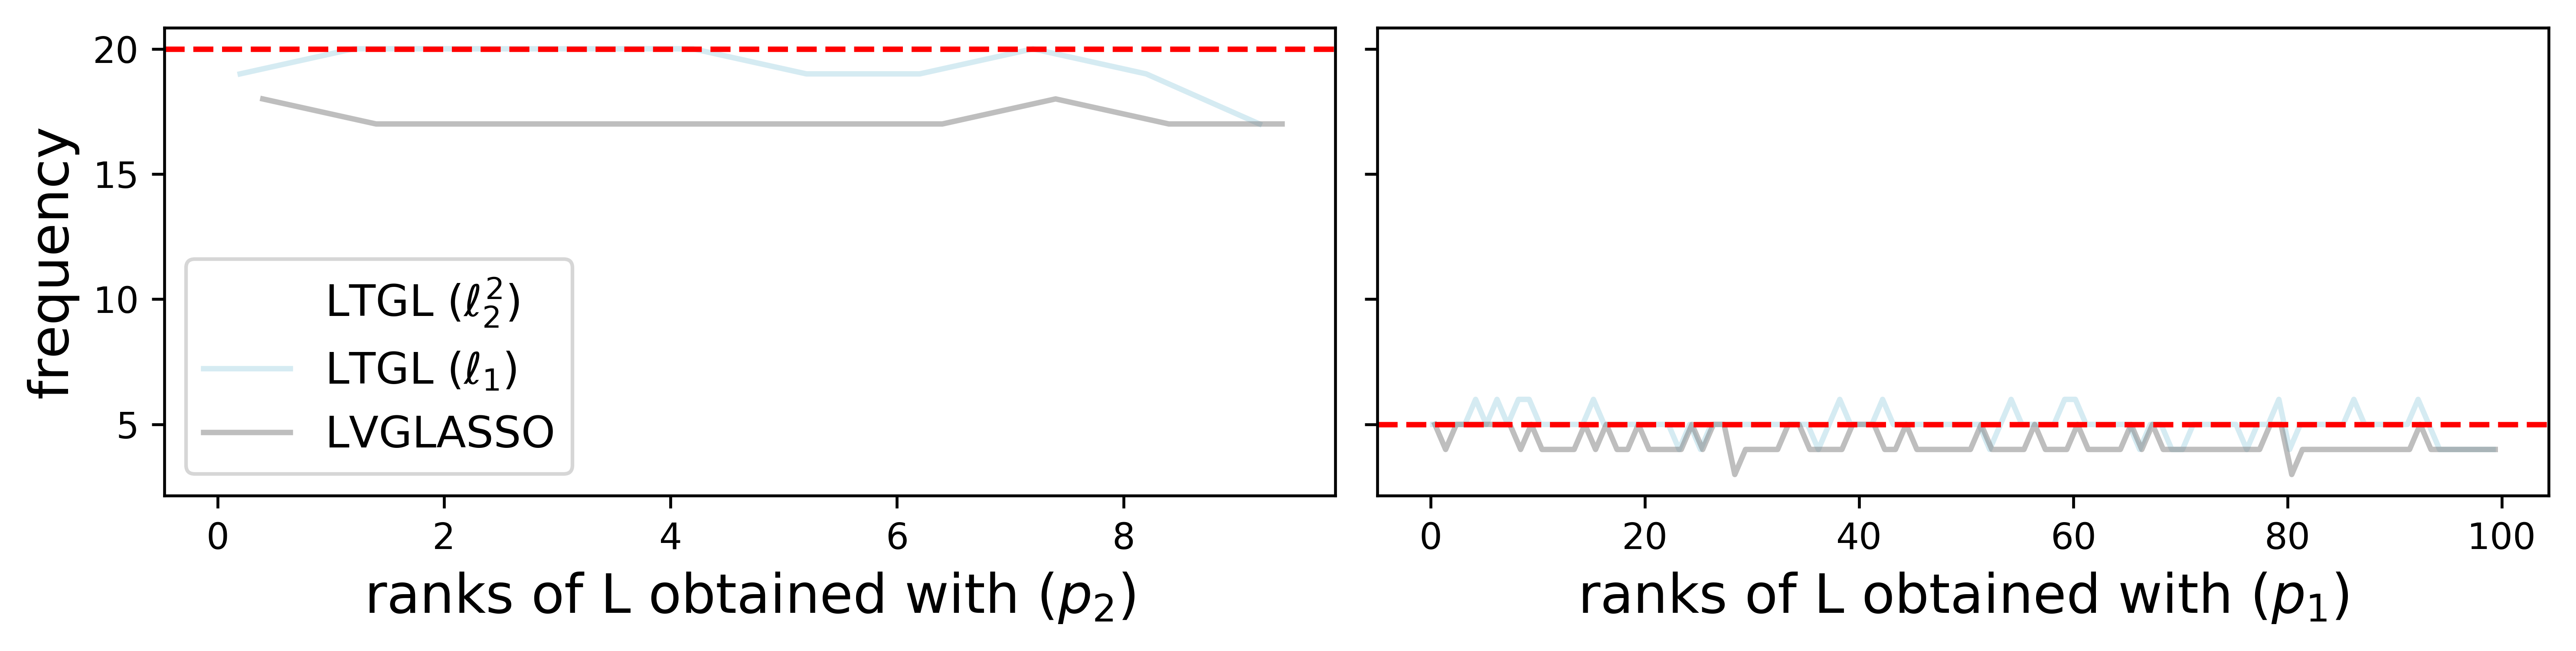

In [82]:
import collections
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,2.6), dpi=600)

colors = ['white', 'lightblue', 'C7']
alpha = 0.5

counter=collections.Counter(l1)
ax1.plot(range(len(l1)), l1, 
        alpha=alpha, label='LTGL ($\ell_2^2$)', color=colors[0])
counter=collections.Counter(l2)
ax1.plot(np.arange(len(l1))+.2, l2, 
        alpha=alpha,  label='LTGL ($\ell_1$)', color=colors[1])
counter=collections.Counter(l3)
ax1.plot(np.arange(len(l1))+.4, l3,
        alpha=alpha, label='LVGLASSO', color=colors[2])

# ax1.set_xticks(range(15,25, 1))
#ax1.set_ylim(0,5)
ax1.axhline(20, c='r', ls='--')
ax1.set_xlabel(r'ranks of L obtained with ($p_2$)')
ax1.set_ylabel('frequency')
ax1.xaxis.label.set_size(15)
ax1.yaxis.label.set_size(15)

#ax1.legend()
# ax0.legend(prop={'size': 10})
# ax0.set_title('bars with legend')


counter=collections.Counter(l4)
ax2.plot(range(len(l4)), l4, 
        alpha=alpha,label='LTGL ($\ell_2^2$)', color=colors[0])
counter=collections.Counter(l5)
ax2.plot(np.arange(len(l4))+.2, l5,
        alpha=alpha,  label='LTGL ($\ell_1$)', color=colors[1])
counter=collections.Counter(l6)
ax2.plot(np.arange(len(l4))+.4, l6, alpha=alpha,label='LVGLASSO', color=colors[2])

# ax2.set_xticks(range(10))
# ax2.set_xlim(2.5,6.7)
ax2.set_xlabel(r'ranks of L obtained with ($p_1$)')
ax2.xaxis.label.set_size(15)
ax2.axhline(5, c='r', ls='--')
ax1.legend(loc='best', fontsize='large')
plt.tight_layout()
plt.show()

In [337]:
# mm.loc[idx[:], idx[['f1', 'accuracy', 'mean_rank_error']]].astype(float).round(3).to_latex(
#     "table_setting_1_5feb.tex", na_rep='-', escape=False)

In [338]:
utils.save_pickle(data, "data_setting_1.pkl")

In [163]:
dff.T.to_latex("arr.tex", float_format='%.2f', na_rep='-')